# ECSE415 Project Report

## Group 19  
****  
**Ali Habib 260658538**  
**Hakim Amarouche 260692167**  
**Pierre-William Breau 260588768**  
**Shi Yu Liu 260683360**    
**Younes Boubekeur 260681484**  

____

# 1 Imports

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math

____

# 2 Classification

##### Description of the contents of the dataset (number of samples and image size, for each label).

The input data set is composed of different categories such as cars, trucks, background, etc. There are approximately 600 000 images. The images are approximately the same size. They all have a low resolution. They are sometimes difficult to distinguish even for humans. The proportion of background images is bigger compared to the other categories.

We loaded 100 images per label, summing up to 1100 images in total for training our model. Having more than a 1100 would not increase our results significantly and would take more time to execute. Each image
was reduced to a 128X128 pixels image to match the block size of our HOG feature detector. However, when resizing the images will change their proportion.

##### Explanation of feature extraction method.

Histogram of gradients (HOG) counts gradients orientations in image regions to determine features.
It is more efficient then SIFT features detector since it is looking at blocks of pixels instead of each pixels by itself.

In the `getHogFeatures()` function a HOG descriptor is created with appropriate dimensions. Then it is iterating over the images and computing the hog features for each, thus obtaining the grandient amplitudes for each direction.
We used HOG, because it is invariant to geometric and photometric transformations. Althought HOG has no compensation for scale, it does not affect our result since the images are from non-moving cameras and there is not to much variation in scale for the sample images.

###### Explanation of how the feature extraction parameters were selected.
The parameters were selected using experimentation. We tried different combinations of cell sizes, block sizes and number of bins that satisfy the HOG constraints and compared the accuracy for each combination. We selected the combination with the best accuracy. 


###### Description of cross-validation method

We used cross-validation with 10 folds offered by sklearn API. The Cross-validation techniques partitions the sample data into subsets using some of it for training and the rest for testing. This process happens K times such that all the data is used for testing and training. The benefint of using K-folds crossvalidation is that it maximizes the amount of data for training and the data for testing. A measurement of the accuracy is then computed from the average of the 10 runs.

##### Evaluation of performance and interpretation of results

Predictive accuracy refers to a model’s ability to accurately predict the class label of new or unseen data. It follows a 0 to 1 loss function using testing examples, where the ratio is equal to 

Nc (number of correctly classified testing examples)/ Nt (total number of testing examples)

In our case we have an accuracy and precision of 45%. While this is a decent percentage, the shortcomings can be linked to the choice of the parameters for the HOG feature extraction. Perahps we should have use different feature extraction methods jointly to get better results. Or maybe the shortcomings can be linked to the choice of the cross validation method. We used k fold cross validation, randomly dividing the data set into k subsamples, using k-1 subsamples as training data and one sub-sample as test data --- repeating k times. The problem with this is that it is computationally very costly and we cannot, and also that it uses small samples of performance estimation; and overlaps training data, which significantly raises error. 


Unfortunately, the results for the accuracy, recall and precision values are all the same when running the program. This is not suppose to happen. We have a bug somewhere that we could not figure out due to time constraint.  

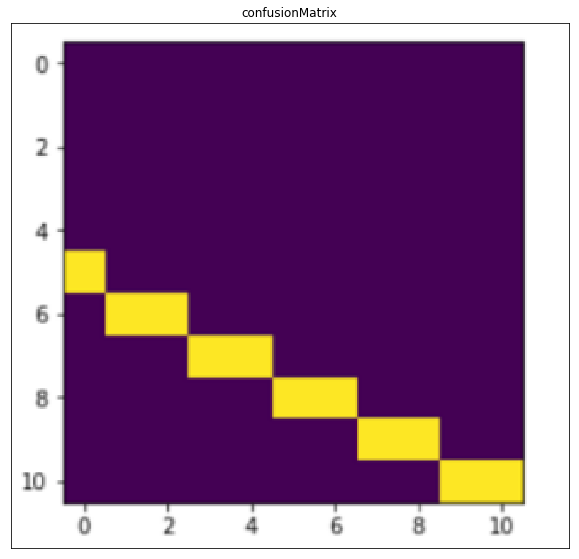

In [3]:


img = cv2.imread("confusionMatrix.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("confusionMatrix"), plt.xticks([]), plt.yticks([])
plt.show()

____

# 3 Localization & Classification

###### Description of the contents of the dataset (e.g., number of samples and bounding box size for each label, contents, etc.) 
The input data set is composed of 110 000 training images and 27 743 testing images. The gt_train.csv file describes for each training image the class and bounding box of each object present therein. The size of the bounding boxes vary.

##### Description of localization method.
Using HoG and our SVM classifier from before, a localization strategy would be the following:
1. For each image, compute the HoG features for the entire image
2. In a pyramid-like fashion, run a sliding window on the image.
3. Resize the image and re-run the sliding window, to account for different scales of objects. The sliding window will query the classifier and based on the response, it will determine the presence of an object. If the classifier detects a background, nothing happens. Any other response will return the presence of an object.

This is likely to lead to many false positives depending on the step size used in the sliding window.

###### Evaluation of localization performance and interpretation of results.
SVM recall is important because it measures the success of prediction in case of having high imbalance between classes. Precision in this case would be a measure of how relevant our results are. Meanwhile, recall is a measure of how many really relevant results are able to be returned. 

When a model has a high recall percentage but a low precision one, it is able to return many results. Nevertheless, the labels it predicts are often not in agreement with the trained labels. Meanwhile, in the opposite case, not many results are returned, but those that are in fact returned have high accuracy in terms of predicting the correct labels. The ideal situation would be to have a high recall AND accuracy percentage.

The problem with HoG is that it is very sensitive to image rotation, which can lead to greater errors. 


# How to run the source code Source code


## Part 2 Classification

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import glob
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from joblib import dump, load
import os
import time


def loadImagesWithLabel(classificationPath, number_images_label, imageSize):
    trainingClassificationPath = os.path.join(classificationPath, 'train')
    labels = os.listdir(trainingClassificationPath) #creates the labels using the folder name at path specified.
    classification_images = [] #list of all images loaded regardless of their class
    trainingLabels = [] #label of image corresponding to the images in classification_images list

    for label in labels:
        path_label = os.path.join(trainingClassificationPath, label)
        for i, image_name in enumerate(os.listdir(path_label)):
            if i == number_images_label:
                break

            image = cv2.imread(os.path.join(path_label, image_name), cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (imageSize, imageSize))
            classification_images.append(image)

            trainingLabels.append(labels.index(label))

    classification_images = np.array(classification_images)
    trainingLabels = np.array(trainingLabels)

    return classification_images, trainingLabels
    
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures

def main():
    images, labels = loadImagesWithLabel("../MIO-TCD-Classification", 100, 128)
    training_img_features = getHogFeatures(images)
    training_img_features = np.array([x.flatten() for x in training_img_features])

    model = svm.SVC(gamma=0.002, kernel='linear')
    
    # save model to file
    dump(model, 'svm_model.joblib')
    
    scores = cross_val_score(model, training_img_features, labels, cv=10)
    print("Accuracy & STD: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    recall = cross_val_score(model, training_img_features, labels, cv=10, scoring='recall_micro')
    print("Recall: %0.2f", np.mean(recall))
    precision = cross_val_score(model, training_img_features, labels, cv=10, scoring='precision_micro')
    print("Precision: %0.2f", np.mean(precision))

if __name__ == "__main__":
    main()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../MIO-TCD-Classification\\train'